# Experiments in Spanish Rhythmization

#### By S. Cafferty

### Ritmo is a module that creates a rhythmic search engine from a list of words. The current version is optimized for Spanish, but the same approach is viable for any language. 

### The objectives are as follows:
- score words based on rhythmic similarity
- weigh scores based on whether the word pairs match in terms of part of speech and prioritize the matching of entities


In [1]:
## Sentence Data
with open('data/all_sents.txt') as f:
    sent_list = [line.rstrip() for line in f]

In [2]:
## Word Data
with open('data/allwords.txt') as f:
    word_list = [line.rstrip() for line in f]

### Firstly, why would you want to use ritmo? Can't measures based on edit distance produce similar results?

- Yes and no. Edit distance is certainly a useful measure, but for tasks such as measuring all words against each other to find the most similar pairs, the process is quite slow. 

For example:

In [3]:
from tqdm import tqdm
import nltk

def get_edit_distances(word_list):
    results = []
    for w1 in tqdm(word_list):
        for w2 in word_list:
            results.append([w1,w2,nltk.edit_distance(w1,w2)])
    return sorted(results, key = lambda x: x[2], reverse=False)

#res = get_edit_distances(word_list)

Running the above code crossreferencing a list of 20000 words by edit distance takes about 6 hours on a CPU, and that's without weighing the results or incorporating parts of speech. As the word lists get larger, this process gets even slower.

```
 0%|          | 24/20000 [00:27<6:21:36,  1.15s/it]
```
As such, it is more reasonable to leverage the speed of vector-based approaches.

### Experimenting with the Ritmo Module:

Ritmo includes two classes: 
- Preprocess() : a class with simple text cleaning and transformation tools, and...
- Rhythmizer() : a class that can be used to create a rhythmic search engine from a list of words.

### Let's give it a try.

In [4]:
import ritmo

P = ritmo.Preprocess()

/Users/sc/opt/anaconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
test_word = 'programador'
test_word_list = ['banana5', '/mango.' ,'oran**ge', 'Pear@'] ## NOTE: capitalization is preserved for spaCy's entity recognition model 

print(P.get_characters(test_word))
print(P.get_ipa(test_word))
print(P.get_sampa(test_word))
print(P.get_ipa_bigram(test_word))
print(P.get_sampa_trigram(test_word))
print(P.clean_word_list(test_word_list))

p r o g r a m a d o r
pɾoɡɾamadoɾ
p4og4amado4
pɾ ɾo oɡ ɡɾ ɾa am ma ad do oɾ
p4o 4og og4 g4a 4am ama mad ado do4
['banana', 'mango', 'orange', 'Pear']


To use the Rhythmizer() class, we instantiate the class, and then add a word list of our choosing. Like so:

```
word_list = ['some', 'long', 'list', 'of', 'words']
R = ritmo.Rhythmizer()
R.add_word_list(word_list)
```

The Rhythmizer() has several default parameters that can be modified:
```
- schema='sampa_bigram',
- pos_weight=True,
- epitran_model='spa-Latn',
- custom_vowels='aeiouáéíóúäëïöüàèìòùAEIOUÁÉÍÓÚÄËÏÓÜÀÈÌÒÙ',
- stop_words=[],
- spacy_model = spacy.load('es_core_news_lg')
```

### Experimenting with Schemas

The following experiment in which average edit distance is applied to a list of nearest neighbors in vector space in order to determine the best available phonetic schema:


In [7]:
import pandas as pd

options = ['syllables_sampa', 'syllables_ipa', 'sampa_bigram', 'ipa_bigram', 'sampa_trigram','ipa_trigram']

def test_schema(options, word_list):
    results = []
    for option in options:
        R = ritmo.Rhythmizer(schema=option)
        R.add_word_list(word_list)
        _, score = R.test()
        results.append(score)
    return pd.DataFrame([results], columns=options).T.rename(columns={0:'score'})

score_df = test_schema(options, word_list) ## Takes about 8 minutes

In [8]:
score_df

,score
syllables_sampa,4.7790
syllables_ipa,4.7865
sampa_bigram,3.8015
ipa_bigram,3.8630
sampa_trigram,3.7425
ipa_trigram,3.7250


In the results above, we see that sampa_trigram produces the best results in terms of edit distance, but not much better than the bigrams, so for the sake of computational speed, the default schema is sampa_bigram. Moreover, 'unseen' trigrams don't get their own embeddings to which words can refer, so it's better to use bigrams.

## Ritmo in Action

Instantiate ritmo class with default parameters:

Note: this can take a few minutes as spaCy retrieves parts of speech and entities

In [3]:
import ritmo
import random
from nltk.corpus import stopwords

stop_words = [sw for sw in stopwords.words('spanish') if len(sw) < 6] + [sw.capitalize() for sw in stopwords.words('spanish')]

R = ritmo.Rhythmizer(schema='sampa_bigram', stop_words=stop_words)

R.add_word_list(word_list)

/Users/sc/opt/anaconda3/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Just for fun we can visualize the subword embeddings:
```
R.visualize_embeddings()
```

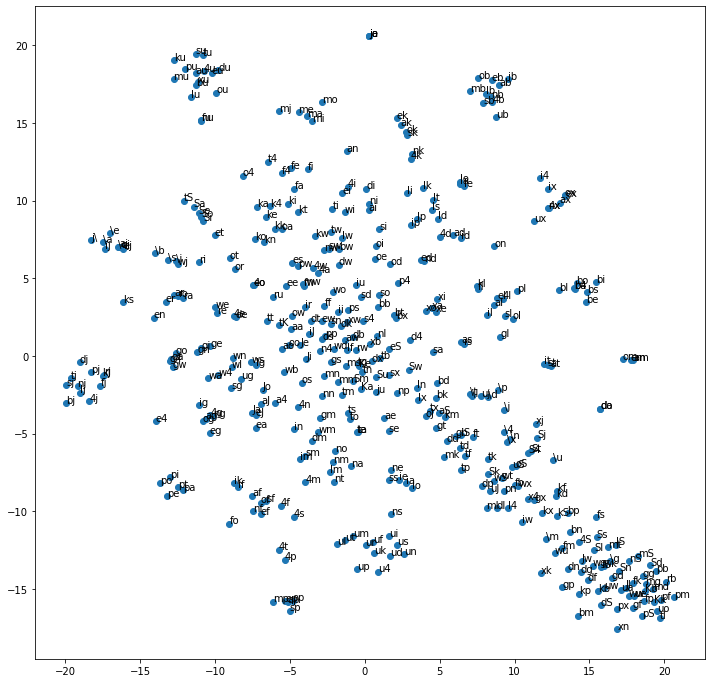

In [19]:
R.visualize_embeddings()

### We can query a word against a sentence:
```
R.rhythmize_word_to_sentence(word : string, sentence : string)
```

In [13]:
# Example

word_ = 'leña'

sent_ = '''Siento otro Yo que contra mí se empeña,
que en todo influye y todo me acibara,
un Yo que si de mí se retirara,
me hiciera ver la vida hasta risueña.'''

R.rhythmize_word_to_sentence(word_,sent_)

,text,score
0,empeña,9.000
1,risueña,8.379
2,retirara,5.166
3,acibara,5.103
4,Siento,2.979
5,vida,2.925
6,hiciera,2.637
7,contra,2.547
8,influye,0.000


In [14]:
word_ = 'polvorosa'

sent_ = """Aura sutil su clámide olorosa
de verde enredadera en los festones
desgarra Melancólicas canciones
flébiles surgen de la selva hojosa

Tiñe el cielo su bóveda azulosa
con lácteas tenuidades de jarrones,
y en el ocaso humeantes bermellones
del sol la veste esparce esplendorosa"""

R.rhythmize_word_to_sentence(word_,sent_)

,text,score
0,olorosa,9.000
1,esplendorosa,7.722
2,hojosa,7.560
3,ocaso,6.174
4,azulosa,5.805
5,bóveda,5.778
6,selva,4.527
7,clámide,4.428
8,Melancólicas,3.735
9,enredadera,3.384


In [15]:
word_ = 'pulmones'

R.rhythmize_word_to_sentence(word_,sent_)

,text,score
0,canciones,9.000
1,festones,8.856
2,jarrones,7.452
3,bermellones,5.904
4,esparce,5.895
5,cielo,5.877
6,lácteas,5.751
7,azulosa,5.409
8,esplendorosa,5.058
9,humeantes,4.869


We can query a word against a the whole vocabulary:
```
query_all_vocab(entry: string, weight=True, pos_weight=True)

weight: refers to the matrix weights related to non-phonetic features
pos_weight: refers to scalar weights that depress/boost scores based on parts of speech
```

The weights are encoded information about POS, entity-ness, word length, and capitalization that are embedded in the vector.
The pos_weights are a scalar array that push down the scores if the given POS is less of a priority. (e.g. 1 for entities and 0.98 for adjectives, etc.)

In [16]:
R.query_all_vocab('Pablo')[:10]

,text,score
0,Pablo,0.996004
1,Pavlos,0.973687
2,Pueblo,0.959337
3,Leyla,0.954651
4,Kabila,0.953228
5,Plaza,0.951771
6,Bloque,0.951536
7,Estilo,0.951175
8,Clare,0.949126
9,Aloès,0.947363


In [17]:
## Without weights

R.query_all_vocab('Pablo',weight=False)[:10] 

,text,score
0,Pablo,1.000000
1,habló,0.936741
2,hablo,0.936741
3,parábola,0.911650
4,hablarlo,0.906442
5,establo,0.904896
6,Pavlos,0.903495
7,palpable,0.895738
8,habla,0.893776
9,culpable,0.886783


In [18]:
R.query_all_vocab('Italia')[:10]


,text,score
0,Italia,0.996669
1,Somalia,0.975605
2,Liberia,0.974158
3,Ucrania,0.971112
4,Instaría,0.971261
5,Cecilia,0.970464
6,Malasia,0.970435
7,Namibia,0.970356
8,Plenaria,0.970171
9,Vitoria,0.969643


In [19]:
## Without weights

R.query_all_vocab('Italia', weight=False)[:10]

,text,score
0,Italia,1.000000
1,KLMAlitalia,0.961356
2,KLMAlitalia,0.961356
3,salía,0.941362
4,evitaría,0.938691
5,solitaria,0.938161
6,enquistaría,0.936367
7,igualitaria,0.933059
8,debilitaría,0.931162
9,Debilitaría,0.931162


In [20]:
R.query_all_vocab('dramáticamente', weight=False)[:10] 

,text,score
0,dramáticamente,1.000000
1,automáticamente,0.997797
2,aritméticamente,0.997103
3,críticamente,0.996540
4,autocráticamente,0.996462
5,teóricamente,0.995695
6,aeronáuticamente,0.995654
7,Prácticamente,0.995388
8,sintéticamente,0.995191
9,Históricamente,0.994941


In [21]:
R.query_all_vocab('vandalizar')[:10] 

,text,score
0,escandalizar,0.957332
1,señalizar,0.956510
2,banalizar,0.956436
3,visualizar,0.956475
4,liberalizar,0.956396
5,sacralizar,0.956308
6,centralizar,0.956321
7,canalizar,0.956086
8,convalidar,0.956079
9,fidelizar,0.955886


## Finding Most Similar Word Pairings in Huge Word Lists

### Ritmo is designed as a super fast search engine, so it's manageable to loop through and cross reference a list of words against itself. We have to do a few preprocessing steps in order to get our desired result. 

In [22]:
P = ritmo.Preprocess()

sentence_words = P.get_sentence_corpus_vocab(sent_list)

100%|██████████| 20000/20000 [00:01<00:00, 10349.82it/s]


In [23]:
### Here we're combining the original word list with a word list derived from a corpus of sentences.

combined_word_list = sorted(list(set(sentence_words + R.clean_word_list_)))                     ## Combine word_list and words from sentences
print(len(combined_word_list))
combined_word_list = [w for w in combined_word_list if len(w) > 2]                              ## Remove entries less than 3 letters
print(len(combined_word_list))
combined_word_list = [w for w in combined_word_list if len(set(w).intersection(P.vowels)) > 0]  ## Remove entries that could be acronyms. 
print(f'Total words: {len(combined_word_list)}')                                                ## NOTE: Acronyms cause trouble for the silabeador library, so be sure to remove them



34735
34601
Total words: 34563


Our combined word lists consist of 34563 words, which means we're going to do over a BILLION comparisons. Luckily, this isn't a problem for ritmo, but will still take about an hour.

In [24]:
R = ritmo.Rhythmizer()

R.add_word_list(combined_word_list)

In [25]:
from tqdm import tqdm
import pandas as pd
import numpy as np

results = []

for word in tqdm(combined_word_list):
    result = R.query_all_vocab(word)
    result['text_2'] = word
    result = result[(result['score'] > .98) & (np.round(result['score'],4) < 1)] ### confine the ranges, because this dataset will be huge
    results.append(result[['text','text_2','score']])

100%|██████████| 34563/34563 [55:33<00:00, 10.37it/s] 


In [29]:
results_df = pd.concat(results).sort_values(by='score', ascending=False)

In [30]:
cleaned_up_df = results_df.loc[~(results_df['text'] == results_df['text_2'])].iloc[::2, :].reset_index(drop=True)


In [31]:
cleaned_up_df['score'] = cleaned_up_df['score'] * 10
cleaned_up_df[:50]

,text,text_2,score
0,BoumedienneThiery,BoumedieneThiery,9.986180
1,Constitucionales,Institucionales,9.985804
2,EuropeaIzquierda,EuropaIzquierda,9.985701
3,BoumédieneThiery,BoumédienneThiery,9.985236
4,Caleidoscopio,CALEIDOSCOPIO,9.984621
5,coresponsabilidad,imprescindibilidad,9.982990
6,Chevènement,Chevenement,9.981826
7,KreissDörfler,KreisslDörfler,9.981456
8,Herefordshire,Staffordshire,9.981141
9,administration,upadministration,9.980821


In [31]:
cleaned_up_df[:10000].to_csv('sample_results.csv')

## Conclusions and Further Research

### This module is certainly fast and effective. However, there are numerous aspects which could be improved.


- This model is currently using sampa ngrams, it would be great to conduct more experiments to see which other schemas might ultimately be most effective.

- Ritmo uses Word2Vec for the sake of ease. However, it would be great to experiment with FastText vectors (to better account for 'unseen' phonetic tokens) as well as BERT embeddings to superimpose positional information. Both aforementioned vectorization schemes would likely be more effective and will be the focus of future projects.

- Some adaptations should certainly be made to account for minor variations in spelling or case.

- The POS is determined with spaCy, which does not work great with single-word inputs. It's necessary to find a more reliable way to determine POS efficiently. I'd like to add a custom POS parameter to better account for cases in which spaCy POS is ambiguous.

- Right now, the weighting scheme is rudimentary and includes information about parts of speech, entities, length, stress, and capitalization. It would be great to improve on this schema. 

- The mathematical properties of the search engine create a scoring scheme that has to be scaled on a case by case basis. It would be great to combine the speed of the search engine with a more standardized scoring system, though it seems that this is a tradeoff. Future iterations of this project will hopefully include a more standardized schema.

- This module is currently designed for use with the Spanish language. Howeover, it would be great to create a tool that can account for any language.

- It would be great to be able to customize the phoneme schema based on dialect, including boolean variables for properties such as 'seseo' and 'yeísmo', etc. 